In [1]:
import xarray as xr
import data_types
import importlib
import matplotlib.pyplot as plt
import numpy as np
from cartopy import crs as ccrs
import seaborn

years=range(2020,2021)

data_dir = '/scratch/cimes/feiyul/Ocean_Data'
# data_dir = '/collab1/data_untrusted/Feiyu.Lu/Ocean_Data'
T_varname = 'thetao_prior_z'
S_varname = 'so_prior_z'
SST_obs_varname = 'sst'
SSS_obs_varname = 'sss'

# Static grid information
# Tripolar grid is indicated by geolat/geolon
ocean_static_ds = xr.open_dataset(f'{data_dir}/model_data/M9/ocean_z.static.nc')
ocean_static_ds['xh']=ocean_static_ds['xh'].where(ocean_static_ds['xh']>0,ocean_static_ds['xh']+360)
ocean_static_ds['xq']=ocean_static_ds['xq'].where(ocean_static_ds['xq']>0,ocean_static_ds['xq']+360)
ocean_static_ds_rolled = ocean_static_ds.roll(xh=60,roll_coords=True).roll(xq=60,roll_coords=True)
geolat= ocean_static_ds_rolled.geolat
geolon= ocean_static_ds_rolled.geolon

# Basin code in addition to land mask from static file
# 1: SO, 2: Atlantic, 3: Pacific, 4: Arctic, 5: Indian, 6: Med, 7...
basin_ds = xr.open_dataset(f'{data_dir}/model_data/M9/basin.nc')
basin_code = basin_ds['basin']

model_dz_ds = xr.open_dataset(f'{data_dir}/model_data/M9/vgrid_75_2m.nc')
model_dz = model_dz_ds.dz
model_z = np.zeros(len(model_dz))
model_z[0] = model_dz[0]/2 
for i in range(1,len(model_dz)):
    model_z[i] = model_z[i-1] + (model_dz[i-1]+model_dz[i])/2
model_zi = np.zeros(len(model_dz)+1)
for i in range(1,len(model_dz)+1):
    model_zi[i] = model_dz[0:i].sum().values

T_ds = xr.open_mfdataset(
    [f'{data_dir}/model_data/M9/ocean_daily.{year}0101-{year}1231.{T_varname}.nc' for year in years])
T_ds['xh']=T_ds['xh'].where(T_ds['xh']>0,T_ds['xh']+360)
T_ds_rolled = T_ds.roll(xh=60,roll_coords=True)
T_var = T_ds_rolled[T_varname]

SST_obs_ds = xr.open_mfdataset(
    [f'{data_dir}/obs_data/sst/sst.day.{year}.1x1.nc' for year in years])
SST_obs_var = SST_obs_ds[SST_obs_varname]

SSS_obs_ds = xr.open_mfdataset(
    [f'{data_dir}/obs_data/sss/SSS.day.{year}.1x1.nc' for year in years])
SSS_obs_var = SSS_obs_ds[SSS_obs_varname]

argo_obs_ds = xr.open_mfdataset(
    [f'{data_dir}/obs_data/argo/argo_{year}.nc' for year in years])

In [2]:
len(argo_obs_ds.station_index)

1020305

In [2]:
T_var

<xarray.DataArray 'thetao_prior_z' (time: 366, z: 75, yh: 320, xh: 360)>
dask.array<rechunk-merge, shape=(366, 75, 320, 360), dtype=float32, chunksize=(366, 75, 320, 360), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2020-01-01 12:00:00 ... 2020-12-31 12:00:00
  * xh       (xh) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * yh       (yh) float64 -77.77 -77.56 -77.34 -77.12 ... 89.26 89.48 89.69 89.9
  * z        (z) float64 1.0 3.0 5.0 7.0 ... 3.338e+03 3.591e+03 5.111e+03
Attributes:
    units:          degC
    long_name:      Accumulated ocean potential temperature for DA/ML
    cell_methods:   area:mean z:mean yh:mean xh:mean time: mean
    time_avg_info:  average_T1,average_T2,average_DT

In [4]:
SST_obs_var

<xarray.DataArray 'sst' (time: 366, lat: 180, lon: 360)>
dask.array<open_dataset-8bebdd16df85fd9e11cabb4df7a0e3d8sst, shape=(366, 180, 360), dtype=float32, chunksize=(366, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) object 2020-01-01 00:00:00 ... 2020-12-31 00:00:00
Attributes:
    long_name:              SST1[GT=TDAY]
    typeConversion_op_ncl:  double converted to float

In [5]:
importlib.reload(data_types)
argo_obs = data_types.argo(argo_obs_ds,meta_only=True)
len(argo_obs)

85555

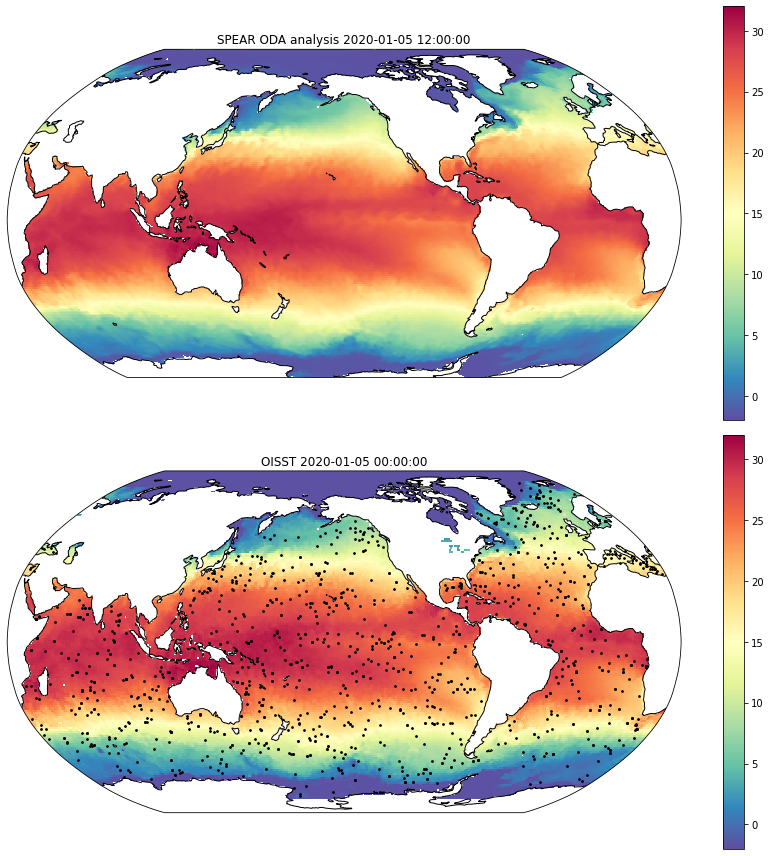

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12,12),
                         subplot_kw={'projection': ccrs.Robinson(210)})

day = 4
period = [np.datetime64('2020-01-03T00:00:00'),
          np.datetime64('2020-01-08T00:00:00')]

indexes = argo_obs.get_profiles_by_all(
    start_time=period[0], end_time=period[1])
    
level = 0
cmap = seaborn.color_palette("Spectral_r", as_cmap=True)

cf0=axes[0].pcolormesh(
    geolon, 
    geolat, 
    T_var.isel(z=level,time=day), 
    vmin=-2, vmax=32, cmap=cmap,
    transform = ccrs.PlateCarree())

cf1=axes[1].pcolormesh(
    SST_obs_var.lon,
    SST_obs_var.lat,
    SST_obs_var.isel(time=day), 
    vmin=-2, vmax=32, cmap=cmap,
    transform = ccrs.PlateCarree())
    
axes[1].scatter(argo_obs.lon[indexes], argo_obs.lat[indexes], 
                s=3, color='black', transform = ccrs.PlateCarree())

axes[0].set_title(f'SPEAR ODA analysis {T_var.time.isel(time=day).values}')
axes[1].set_title(f'OISST {SST_obs_var.time.isel(time=day).values}')
fig.colorbar(cf0, ax=axes[0])
fig.colorbar(cf1, ax=axes[1])

for ax in axes:
    ax.coastlines()

fig.tight_layout()

<xarray.DataArray 'sst' (lat: 126, lon: 128)>
dask.array<getitem, shape=(126, 128), dtype=float32, chunksize=(126, 128), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -61.5 -60.5 -59.5 -58.5 -57.5 ... 60.5 61.5 62.5 63.5
  * lon      (lon) float32 120.5 121.5 122.5 123.5 ... 244.5 245.5 246.5 247.5
    time     object 2020-01-05 00:00:00
Attributes:
    long_name:              SST1[GT=TDAY]
    typeConversion_op_ncl:  double converted to float
-1.8
31.897877
<xarray.DataArray 'sss' (lat: 126, lon: 128)>
dask.array<getitem, shape=(126, 128), dtype=float32, chunksize=(126, 128), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -61.5 -60.5 -59.5 -58.5 -57.5 ... 60.5 61.5 62.5 63.5
  * lon      (lon) float32 120.5 121.5 122.5 123.5 ... 244.5 245.5 246.5 247.5
    time     datetime64[ns] 2020-01-05T12:00:00
Attributes:
    depth:          0.0
    long_name:      sea surface salinity
    standard_name:  sea_surface_salinity
    units:          .001
    cell

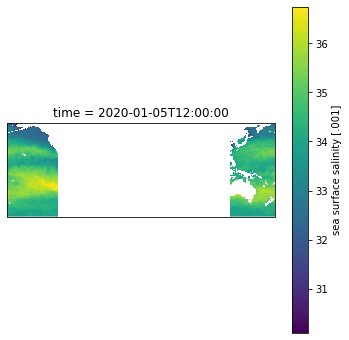

In [2]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,6),
                         subplot_kw={'projection': ccrs.PlateCarree()})

day = 4
level = 0
period = [np.datetime64('2020-01-03T00:00:00'),
          np.datetime64('2020-01-08T00:00:00')]
lat_min = 28
lat_max = 154
lon_min = 120
lon_max = 248
# print(SST_obs_var)
data_slice=SST_obs_var.isel(time=day).isel(lon=slice(lon_min,lon_max),lat=slice(lat_min,lat_max))
print(data_slice)
print(data_slice.min().values)
print(data_slice.max().values)
data_slice=SSS_obs_var.isel(time=day).isel(lon=slice(lon_min,lon_max),lat=slice(lat_min,lat_max))
print(data_slice)
print(data_slice.min().values)
print(data_slice.max().values)
data_slice.plot()

In [ ]:
indexes = argo_obs.get_profiles_by_all(
    start_time=period[0], end_time=period[1],
    lat_min=lat_min,lat_max=lat_max,lon_min=lon_min,lon_max=lon_max)
cmap = seaborn.color_palette("Spectral_r", as_cmap=True)

cf0=axes[0].pcolormesh(
    geolon.sel(xh=slice(lon_min,lon_max),yh=slice(lat_min,lat_max)), 
    geolat.sel(xh=slice(lon_min,lon_max),yh=slice(lat_min,lat_max)), 
    T_var.isel(z=level,time=day).sel(xh=slice(lon_min,lon_max),yh=slice(lat_min,lat_max)), 
    vmin=-2, vmax=32, cmap=cmap,
    transform = ccrs.PlateCarree())

cf1=axes[1].pcolormesh(
    SST_obs_var.lon.sel(lon=slice(lon_min,lon_max)),
    SST_obs_var.lat.sel(lat=slice(lat_min,lat_max)),
    SST_obs_var.isel(time=day).sel(lon=slice(lon_min,lon_max),lat=slice(lat_min,lat_max)), 
    vmin=-2, vmax=32, cmap=cmap,
    transform = ccrs.PlateCarree())

axes[1].scatter(argo_obs.lon[indexes], argo_obs.lat[indexes], 
                s=5, color='black', transform = ccrs.PlateCarree())

axes[0].set_title(f'SPEAR ODA analysis {T_var.time.isel(time=day).values}')
axes[1].set_title(f'OISST {SST_obs_var.time.isel(time=day).values}')
fig.colorbar(cf0, ax=axes[0])
fig.colorbar(cf1, ax=axes[1])

for ax in axes:
    ax.coastlines()

# fig.tight_layout()

In [ ]:

indexes = argo_obs.get_profiles_by_all(
    start_time=period[0], end_time=period[1],
    lat_min=lat_min,lat_max=lat_max,lon_min=lon_min,lon_max=lon_max)
level = 0
cmap = seaborn.color_palette("Spectral_r", as_cmap=True)

cf0=axes[0].pcolormesh(
    geolon.sel(xh=slice(lon_min,lon_max),yh=slice(lat_min,lat_max)), 
    geolat.sel(xh=slice(lon_min,lon_max),yh=slice(lat_min,lat_max)), 
    T_var.isel(z=level,time=day).sel(xh=slice(lon_min,lon_max),yh=slice(lat_min,lat_max)), 
    vmin=-2, vmax=32, cmap=cmap,
    transform = ccrs.PlateCarree())

cf1=axes[1].pcolormesh(
    SST_obs_var.lon.sel(lon=slice(lon_min,lon_max)),
    SST_obs_var.lat.sel(lat=slice(lat_min,lat_max)),
    SST_obs_var.isel(time=day).sel(lon=slice(lon_min,lon_max),lat=slice(lat_min,lat_max)), 
    vmin=-2, vmax=32, cmap=cmap,
    transform = ccrs.PlateCarree())

axes[1].scatter(argo_obs.lon[indexes], argo_obs.lat[indexes], 
                s=5, color='black', transform = ccrs.PlateCarree())

axes[0].set_title(f'SPEAR ODA analysis {T_var.time.isel(time=day).values}')
axes[1].set_title(f'OISST {SST_obs_var.time.isel(time=day).values}')
fig.colorbar(cf0, ax=axes[0])
fig.colorbar(cf1, ax=axes[1])

for ax in axes:
    ax.coastlines()

# fig.tight_layout()

In [2]:
importlib.reload(data_types)
combine_levels = range(0,len(model_dz)+1,3)
model_dz_coarse, model_z_coarse = data_types.depth_vertical_coarsen(model_dz,combine_levels)
T_var_coarse = data_types.variable_vertical_coarsen(T_var,model_dz,combine_levels)

In [3]:
T_var_coarse

<xarray.DataArray (time: 366, z: 25, yh: 320, xh: 360)>
array([[[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         ...,
         [-1.8508376 , -1.8517371 , -1.8499241 , ..., -1.8213809 ,
          -1.8410807 , -1.8498005 ],
         [-1.846159  , -1.8512831 , -1.846362  , ..., -1.8204268 ,
          -1.8379503 , -1.8406346 ],
         [-1.886549  ,  0.        , -1.8469576 , ..., -1.8158695 ,
          -1.8351568 , -1.8362759 ]],

        [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
...
         [-1.4716109 , -1.6667204 , -1.4733263 , ..., -1.2421001 ,
          -1.1809255 , -1.2102964 ],
         [-1.2985041 , -1.6960671 , -1.7157202 , ..., -1.1979039 ,
          -1.1716484 , -1.3342793 ],
         [-1.8679445 ,  0.        , -1.5130583 , ..., -1.1244922 ,
          -1.0644193 , -1.0183693 ]],

        [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         ...,
         [-1.4716109 , -1.6667204 , -1.4733263 , ..., -1.2421001 ,
          -1.1809255 , -1.2102964 ],
         [-1.2985041 , -1.6960671 , -1.7157202 , ..., -1.1979039 ,
          -1.1716484 , -1.3342793 ],
         [-1.8679445 ,  0.        , -1.5130583 , ..., -1.1244922 ,
          -1.0644193 , -1.0183693 ]]]], dtype=float32)
Coordinates:
  * time     (time) object 2020-01-01 12:00:00 ... 2020-12-31 12:00:00
  * z        (z) float64 3.0 9.01 15.07 21.29 ... 4.628e+03 5.375e+03 6.125e+03
  * yh       (yh) float64 -77.77 -77.56 -77.34 -77.12 ... 89.26 89.48 89.69 89.9
  * xh       (xh) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5

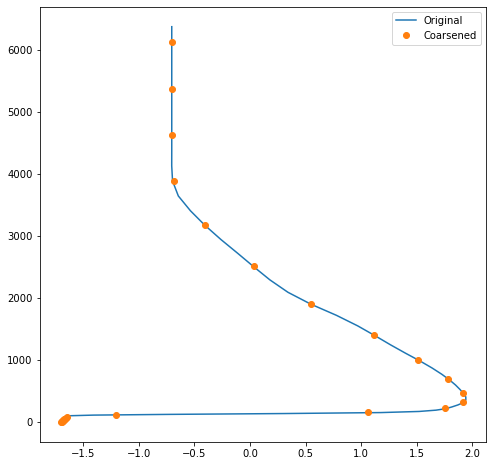

In [5]:
rng = np.random.default_rng()
itime = rng.integers(0,len(T_var.time))
ilat = rng.integers(0,len(T_var.yh))
ilon = rng.integers(0,len(T_var.xh))
while (basin_code[ilat,ilon]>3 or basin_code[ilat,ilon]==0):
    ilat = rng.integers(0,len(T_var.yh))
    ilon = rng.integers(0,len(T_var.xh))
    
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.plot(T_var.isel(time=itime,xh=ilon,yh=ilat),model_z,label='Original')
ax.plot(T_var_coarse.isel(time=itime,xh=ilon,yh=ilat),T_var_coarse.z,'o',label='Coarsened')
ax.legend()

In [ ]:
T_ds_coarse = xr.Dataset(dict(T=T_var_coarse.astype('float32')))
T_ds_coarse.to_netcdf(f'{data_dir}/model_data/M9/T.{years[0]}.nc')